In [1]:
from pathlib import Path
import pickle
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from morphological_tagging.metrics import RunningStats

EVAL_FILES_PATH = "./morphological_tagging/eval"

model = "UDPipe2"

lang_stats = defaultdict(dict)

In [2]:
eval_data = dict()
for eval_fp in Path(EVAL_FILES_PATH).glob(f"**/{model}*.pickle"):
    _, lang, _, _, _ = eval_fp.parts[-1].rsplit("_")

    if eval_data.get(lang, True):
        data = []
        with open(eval_fp, "rb") as fr:
            try:
                while True:
                    data.append(pickle.load(fr))
            except EOFError:
                pass

        eval_data[lang] = data

    else:
        print(f"Language {lang} already processed, skipping.")

In [3]:
langs = sorted(list(eval_data.keys()))
N_langs = len(langs)

# Lemmatization

## Accuracy

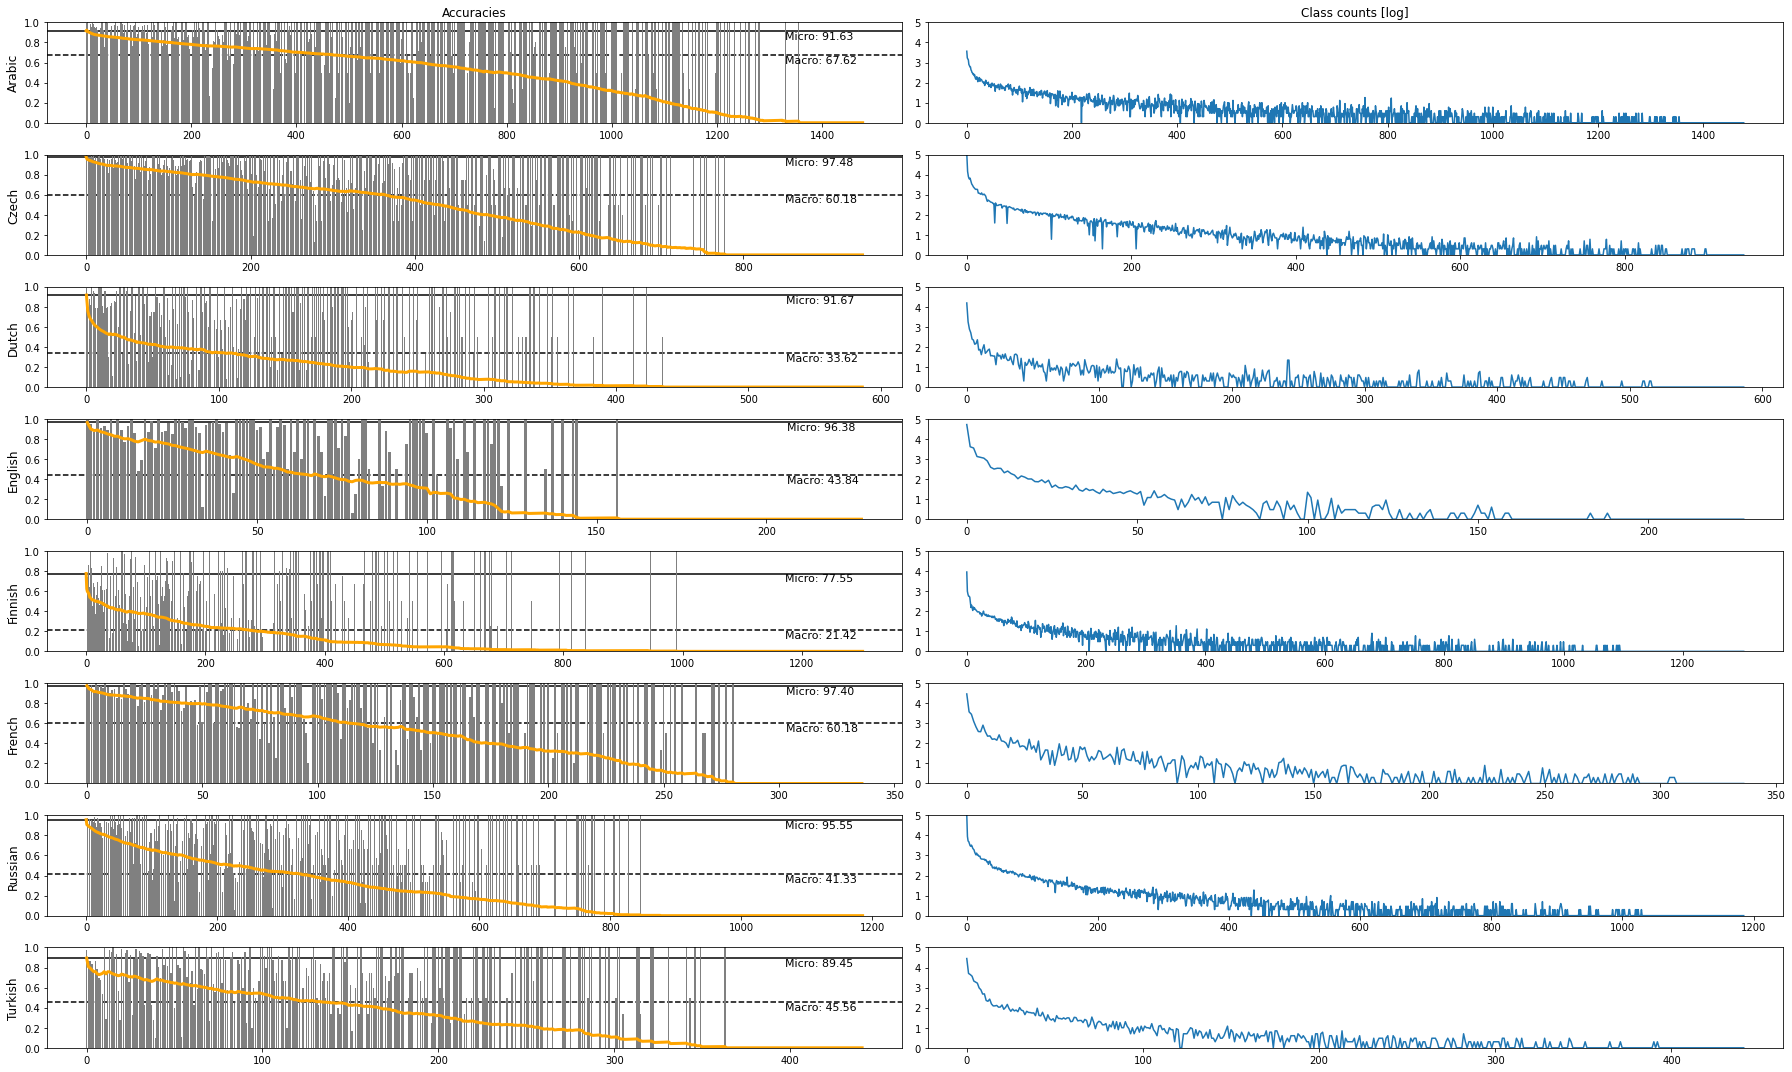

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=N_langs, figsize=(25, 15))

for row, axes_row in enumerate(axes):

    acc_stats = defaultdict(RunningStats)
    for tok in eval_data[langs[row]]:
        acc_stats[tok[3]](int(tok[3] == tok[4]))
    acc_stats = dict(acc_stats)

    x, stats = list(map(list, zip(*sorted(acc_stats.items(), key=lambda x: x[0]))))
    N, mean = np.array([s.N for s in stats]), np.array([s.mean for s in stats])

    micro_mean = np.sum(N * mean) / np.sum(N)
    macro_mean = np.mean(mean)

    for col, ax in enumerate(axes_row):

        if col == 0:
            # First column: accuracies

            # Barplot of accuracy per class
            ax.bar(np.arange(len(N)), mean, color='gray', zorder=0)

            # Plot micro-mean
            ax.axhline(y=micro_mean, c='black', ls='-', zorder=-1)
            ax.text(int(0.90 * len(N)), micro_mean-0.08, f'Micro: {micro_mean*100:.2f}', size=11, color='black')

            # Plot macro-mean
            ax.axhline(y=macro_mean, c='black', ls='--', zorder=-1)
            ax.text(int(0.90 * len(N)), macro_mean-0.08, f'Macro: {macro_mean*100:.2f}', size=11, color='black')

            # Plot micro-mean per excluded class
            micro_means = [np.sum(N[i:] * mean[i:]) / np.sum(N[i:]) for i in range(len(N))]
            ax.plot(micro_means, c='orange', zorder=1, linewidth=3)

            # Set titles and such
            if row == 0:
                ax.set_title("Accuracies", size=12)

            ax.set_ylabel(langs[row], size=12)

            ax.set_ylim(0.0, 1.0)

            lang_stats[langs[row]].update({
                "Lemma/Acc. Micro": micro_mean,
                "Lemma/Acc. Micro @ 2": micro_means[2],
                "Lemma/Acc. Micro @ 10": micro_means[10],
                "Lemma/Acc. Micro @ 100": micro_means[100],
                "Lemma/Acc. Macro": macro_mean,
            })

        if col == 1:
            # Second column: class occurence

            ax.plot(np.log10(N))

            if row == 0:
                ax.set_title("Class counts [log]", size=12)

            ax.set_ylim(0.0, 5.0)

    plt.tight_layout()

All languages perform poorly when lemma scripts become less frequent. The rate of decay, see gap between micro and macro averaged mean accuracies or the strength of the orange line, seems to be caused by the size of the training dataset and the complexity of the language (strongly correlated). Micro-averaged performance seems to be largely dominated by the most common classes, and in turn by the dataset size.

## Edit Distance

In [5]:
from morphological_tagging.data.sigmorphon_2019.evaluation.evaluate_2019_task2 import distance

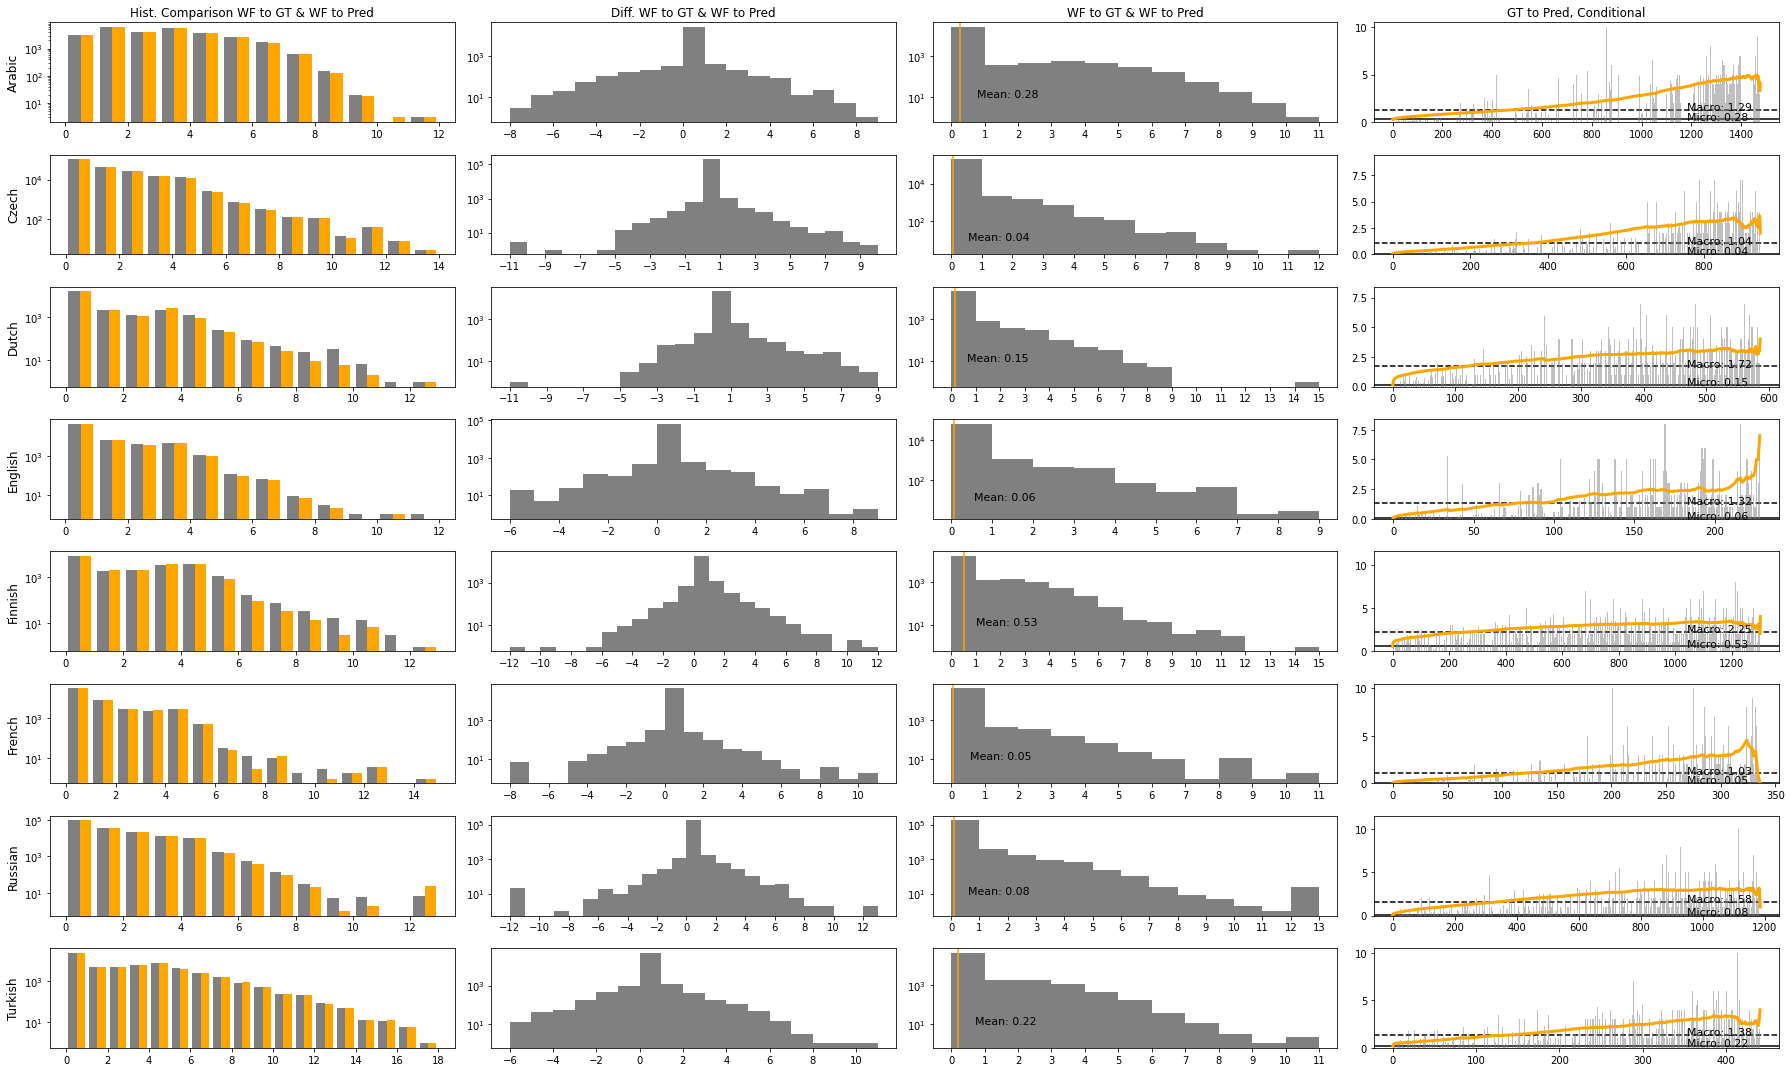

In [6]:
fig, axes = plt.subplots(nrows=N_langs, ncols=4, figsize=(25, 15))

for row, axes_row in enumerate(axes):

    dist_stats = []
    dist_stats_conditional = defaultdict(RunningStats)
    for tok in eval_data[langs[row]]:
        wf_to_lm = distance(tok[0], tok[1])
        wf_to_out = distance(tok[0], tok[2])
        lm_to_out = distance(tok[1], tok[2])

        dist_stats.append([wf_to_lm, wf_to_out, wf_to_lm - wf_to_out, lm_to_out])
        dist_stats_conditional[tok[3]](lm_to_out)

    wf_to_lm, wf_to_out, wf_to_error, lm_to_out = list(map(list, zip(*dist_stats)))
    dist_stats_conditional = dict(dist_stats_conditional)

    for col, ax in enumerate(axes_row):

        if col == 0:
            ax.set_ylabel(langs[row], size=12)

            bins = np.linspace(0, np.max(wf_to_lm)+1, np.max(wf_to_lm)+2)

            ax.hist([wf_to_lm, wf_to_out], bins=bins, color=['gray', 'orange'])

            ax.set_xticks(bins[::2])
            ax.set_yscale("log")

            if row == 0:
                ax.set_title("Hist. Comparison WF to GT & WF to Pred", size=12)

        if col == 1:

            bins = np.linspace(np.min(wf_to_error), np.max(wf_to_error)+1, np.max(wf_to_error)-np.min(wf_to_error)+2)

            ax.hist(wf_to_error, bins=bins, color='gray')

            ax.set_xticks(bins[::2])
            ax.set_yscale("log")

            if row == 0:
                ax.set_title("Diff. WF to GT & WF to Pred", size=12)

        if col == 2:

            bins = np.linspace(0, np.max(lm_to_out)+1, np.max(lm_to_out)+2)

            ax.hist(lm_to_out, bins=bins, color='gray')

            # Plot mean
            mean = np.mean(lm_to_out)
            ax.axvline(x=mean, c='orange', ls='-', zorder=2)
            ax.text(mean+0.5, 10, f'Mean: {mean:.2f}', size=11, color='black')

            ax.set_xticks(bins)
            ax.set_yscale("log")

            if row == 0:
                ax.set_title("WF to GT & WF to Pred", size=12)

        if col == 3:

            x, stats = list(map(list, zip(*sorted(dist_stats_conditional.items(), key=lambda x: x[0]))))
            N, mean = np.array([s.N for s in stats]), np.array([s.mean for s in stats])

            micro_mean = np.sum(N * mean) / np.sum(N)
            macro_mean = np.mean(mean)

            # Barplot of accuracy per class
            ax.bar(np.arange(len(N)), mean, color='gray', zorder=0, alpha=0.5)

            # Plot micro-mean
            ax.axhline(y=micro_mean, c='black', ls='-', zorder=-1)
            ax.text(int(0.80 * len(N)), micro_mean-0.08, f'Micro: {micro_mean:.2f}', size=11, color='black')

            # Plot macro-mean
            ax.axhline(y=macro_mean, c='black', ls='--', zorder=-1)
            ax.text(int(0.80 * len(N)), macro_mean-0.08, f'Macro: {macro_mean:.2f}', size=11, color='black')

            # Plot micro-mean per excluded class
            ax.plot([np.sum(N[i:] * mean[i:]) / np.sum(N[i:]) for i in range(len(N))], c='orange', zorder=1, linewidth=3)

            # Set titles and such
            if row == 0:
                ax.set_title("GT to Pred, Conditional", size=12)

        lang_stats[langs[row]].update({
            "Lemma/Lev. Dist. Micro": micro_mean,
            "Lemma/Lev. Dist. Macro": macro_mean,
        })

plt.tight_layout()

### Without Capitalization

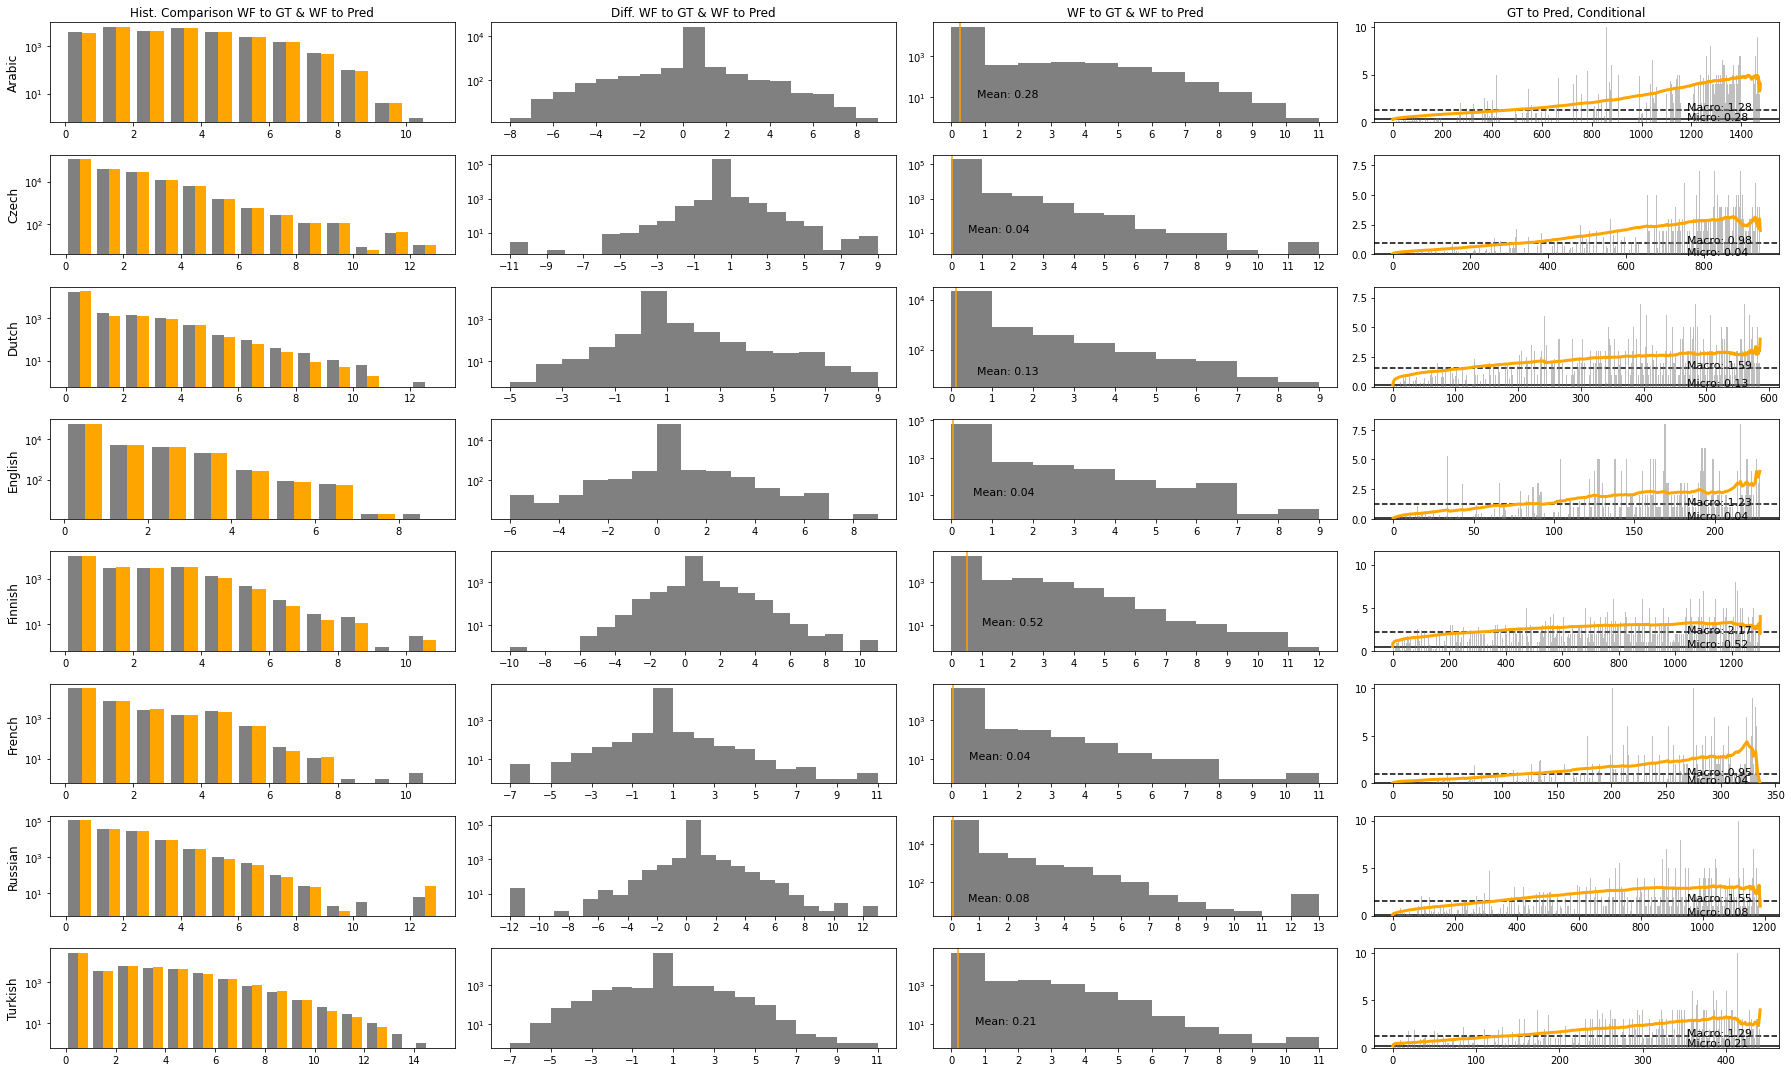

In [7]:
fig, axes = plt.subplots(nrows=N_langs, ncols=4, figsize=(25, 15))

for row, axes_row in enumerate(axes):

    dist_stats = []
    dist_stats_conditional = defaultdict(RunningStats)
    for tok in eval_data[langs[row]]:
        wf_to_lm = distance(tok[0].lower(), tok[1].lower())
        wf_to_out = distance(tok[0].lower(), tok[2].lower())
        lm_to_out = distance(tok[1].lower(), tok[2].lower())

        dist_stats.append([wf_to_lm, wf_to_out, wf_to_lm - wf_to_out, lm_to_out])
        dist_stats_conditional[tok[3]](lm_to_out)

    wf_to_lm, wf_to_out, wf_to_error, lm_to_out = list(map(list, zip(*dist_stats)))
    dist_stats_conditional = dict(dist_stats_conditional)

    for col, ax in enumerate(axes_row):

        if col == 0:
            ax.set_ylabel(langs[row], size=12)

            bins = np.linspace(0, np.max(wf_to_lm)+1, np.max(wf_to_lm)+2)

            ax.hist([wf_to_lm, wf_to_out], bins=bins, color=['gray', 'orange'])

            ax.set_xticks(bins[::2])
            ax.set_yscale("log")

            if row == 0:
                ax.set_title("Hist. Comparison WF to GT & WF to Pred", size=12)

        if col == 1:

            bins = np.linspace(np.min(wf_to_error), np.max(wf_to_error)+1, np.max(wf_to_error)-np.min(wf_to_error)+2)

            ax.hist(wf_to_error, bins=bins, color='gray')

            ax.set_xticks(bins[::2])
            ax.set_yscale("log")

            if row == 0:
                ax.set_title("Diff. WF to GT & WF to Pred", size=12)

        if col == 2:

            bins = np.linspace(0, np.max(lm_to_out)+1, np.max(lm_to_out)+2)

            ax.hist(lm_to_out, bins=bins, color='gray')

            # Plot mean
            mean = np.mean(lm_to_out)
            ax.axvline(x=mean, c='orange', ls='-', zorder=2)
            ax.text(mean+0.5, 10, f'Mean: {mean:.2f}', size=11, color='black')

            ax.set_xticks(bins)
            ax.set_yscale("log")

            if row == 0:
                ax.set_title("WF to GT & WF to Pred", size=12)

        if col == 3:

            x, stats = list(map(list, zip(*sorted(dist_stats_conditional.items(), key=lambda x: x[0]))))
            N, mean = np.array([s.N for s in stats]), np.array([s.mean for s in stats])

            micro_mean = np.sum(N * mean) / np.sum(N)
            macro_mean = np.mean(mean)

            # Barplot of accuracy per class
            ax.bar(np.arange(len(N)), mean, color='gray', zorder=0, alpha=0.5)

            # Plot micro-mean
            ax.axhline(y=micro_mean, c='black', ls='-', zorder=-1)
            ax.text(int(0.80 * len(N)), micro_mean-0.08, f'Micro: {micro_mean:.2f}', size=11, color='black')

            # Plot macro-mean
            ax.axhline(y=macro_mean, c='black', ls='--', zorder=-1)
            ax.text(int(0.80 * len(N)), macro_mean-0.08, f'Macro: {macro_mean:.2f}', size=11, color='black')

            # Plot micro-mean per excluded class
            ax.plot([np.sum(N[i:] * mean[i:]) / np.sum(N[i:]) for i in range(len(N))], c='orange', zorder=1, linewidth=3)

            # Set titles and such
            if row == 0:
                ax.set_title("GT to Pred, Conditional", size=12)

plt.tight_layout()

### Vocab

In [8]:
set_of_lemmas = defaultdict(set)
set_of_pred_lemmas = defaultdict(set)

for lang in langs:
    for tok in eval_data[lang]:
        set_of_lemmas[lang].update([tok[1].lower()])
        set_of_pred_lemmas[lang].update([tok[2].lower()])

    lang_stats[lang].update({
        "Lemma/Vocab Growth": (len(set_of_pred_lemmas[lang]) - len(set_of_lemmas[lang])) / len(set_of_lemmas[lang])
        })

In [9]:
list(set_of_pred_lemmas["Dutch"] - set_of_lemmas["Dutch"])[:25]

['honderdduizend',
 'toegezegd',
 'amerikan',
 'mandate',
 'consultatiebure',
 'frans-belgische',
 'af_zetten',
 'homogean',
 'meedoen',
 'aan_vallen',
 'gen_otee',
 'in_nemen',
 'verlitn',
 '32st',
 'aan_lesen',
 'partijvoor_zitter',
 'mengewijrkt',
 'discussieren',
 'werkg_roep',
 'arbeidskrachte',
 'nederlandstal',
 'benadrken',
 'eenheidswet',
 'klasse',
 'districtenstelsel']

In [10]:
list(set_of_pred_lemmas["English"] - set_of_lemmas["English"])[:25]

['exchang',
 'fishing',
 'noticing',
 'skinn',
 'spoken',
 'resolv',
 'zery',
 'elder',
 'growing',
 'proceedings',
 'violently',
 'blues',
 'li',
 'hott',
 'unmarked',
 'advertising',
 'knitt',
 'lighting',
 'thousan',
 'implie',
 'amaze',
 'freer',
 '15,000',
 'grinn',
 'oncoming']

# Morphological Tagging

In [11]:
lang_stats_morph = defaultdict(dict)
for lang in langs:
    example_pred = eval_data[lang][0][5]
    lang_tp = np.zeros_like(example_pred)
    lang_p = np.zeros_like(example_pred)
    lang_pp = np.zeros_like(example_pred)
    lang_tag_acc = np.zeros_like(example_pred)
    lang_set_acc = RunningStats()

    for tok in eval_data[lang]:
        lang_tp += np.logical_and(tok[5], tok[6]).astype(int)
        lang_p  += tok[6]
        lang_pp += tok[5]

        matches = tok[5] == tok[6]
        lang_tag_acc += matches.astype(int)
        lang_set_acc(np.all(matches))

    lang_pecision = np.nan_to_num(lang_tp / lang_pp, copy=False, nan=0)
    lang_recall = np.nan_to_num(lang_tp / lang_p, copy=False, nan=0)
    lang_f1 = np.nan_to_num(2 * (lang_pecision * lang_recall) / (lang_pecision + lang_recall), copy=False, nan=0)
    lang_micro_f1, lang_macro_f1 = np.sum(lang_p * lang_f1) / np.sum(lang_p), np.mean(lang_f1)

    lang_tag_acc = lang_tag_acc / lang_set_acc.N
    lang_tag_acc_micro, lang_tag_acc_macro = np.sum(lang_p * lang_tag_acc) / np.sum(lang_p), np.mean(lang_tag_acc)

    lang_stats[lang].update({
        "Morph/Set Acc.": lang_set_acc.mean,
        "Morph/Tag Acc. Micro": lang_tag_acc_micro,
        "Morph/Tag Acc. Macro": lang_tag_acc_macro,
        "Morph/Tag F1. Micro": lang_micro_f1,
        "Morph/Tag F1. Macro": lang_macro_f1
    })

    lang_stats_morph[lang].update({
        "Morph/Set Acc.": lang_set_acc.mean,
        "Morph/Tag Acc. Micro": lang_tag_acc_micro,
        "Morph/Tag Acc. Macro": lang_tag_acc_macro,
        "Morph/Tag F1. Micro": lang_micro_f1,
        "Morph/Tag F1. Macro": lang_macro_f1
    })

C:\Users\ivoon\AppData\Local\Temp/ipykernel_11476/2306161681.py:19: RuntimeWarning: invalid value encountered in true_divide
  lang_pecision = np.nan_to_num(lang_tp / lang_pp, copy=False, nan=0)
C:\Users\ivoon\AppData\Local\Temp/ipykernel_11476/2306161681.py:20: RuntimeWarning: invalid value encountered in true_divide
  lang_recall = np.nan_to_num(lang_tp / lang_p, copy=False, nan=0)
C:\Users\ivoon\AppData\Local\Temp/ipykernel_11476/2306161681.py:21: RuntimeWarning: invalid value encountered in true_divide
  lang_f1 = np.nan_to_num(2 * (lang_pecision * lang_recall) / (lang_pecision + lang_recall), copy=False, nan=0)


In [12]:
example_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [13]:
pd.DataFrame.from_dict(lang_stats_morph, orient="index")

,Morph/Set Acc.,Morph/Tag Acc. Micro,Morph/Tag Acc. Macro,Morph/Tag F1. Micro,Morph/Tag F1. Macro
Arabic,0.862449,0.980009,0.990461,0.946886,0.788674
Czech,0.895978,0.991499,0.995791,0.970114,0.898841
Dutch,0.890908,0.984788,0.992727,0.933744,0.847548
English,0.888350,0.986543,0.993707,0.935281,0.867418
Finnish,0.715588,0.966683,0.987539,0.899200,0.558930
French,0.907692,0.990038,0.995877,0.964417,0.845493
Russian,0.892128,0.990539,0.994942,0.959531,0.854667
Turkish,0.735274,0.957507,0.988106,0.883160,0.517637


# Summary

In [14]:
df = pd.DataFrame.from_dict(lang_stats, orient="index")
df.columns = pd.MultiIndex.from_tuples([tuple(col_name.split("/")) for col_name in df.columns])

df

Lemma                                                             \
        Acc. Micro Acc. Micro @ 2 Acc. Micro @ 10 Acc. Micro @ 100 Acc. Macro   
Arabic    0.916345       0.917537        0.889651         0.827080   0.676248   
Czech     0.974766       0.948779        0.923544         0.829632   0.601787   
Dutch     0.916707       0.707125        0.576630         0.342832   0.336189   
English   0.963762       0.883403        0.809237         0.308642   0.438359   
Finnish   0.775509       0.598089        0.513774         0.371257   0.214220   
French    0.974030       0.932492        0.883169         0.666183   0.601822   
Russian   0.955475       0.901724        0.860200         0.652281   0.413312   
Turkish   0.894463       0.794937        0.759106         0.538549   0.455590   

                                                           Morph  \
        Lev. Dist. Micro Lev. Dist. Macro Vocab Growth  Set Acc.   
Arabic          0.277191         1.286420     0.002172  0.862449   
Czech           0.044125         1.036594     0.011861  0.895978   
Dutch           0.152799         1.718219    -0.000670  0.890908   
English         0.058089         1.320643    -0.005235  0.888350   
Finnish         0.531314         2.245011     0.074126  0.715588   
French          0.049092         1.034897    -0.003176  0.907692   
Russian         0.084522         1.582805     0.017769  0.892128   
Turkish         0.219787         1.380743    -0.001239  0.735274   

                                                                   
        Tag Acc. Micro Tag Acc. Macro Tag F1. Micro Tag F1. Macro  
Arabic        0.980009       0.990461      0.946886      0.788674  
Czech         0.991499       0.995791      0.970114      0.898841  
Dutch         0.984788       0.992727      0.933744      0.847548  
English       0.986543       0.993707      0.935281      0.867418  
Finnish       0.966683       0.987539      0.899200      0.558930  
French        0.990038       0.995877      0.964417      0.845493  
Russian       0.990539       0.994942      0.959531      0.854667  
Turkish       0.957507       0.988106      0.883160      0.517637